# Kalevala analysis

This part is about finding the keywords of poems and visualizing similarity between poems. 

First we find keywords by calculating term frequency–inverse document frequency ([Wikipedia tfidf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)) and selecting the ones with highest tf-idf. The result can be used also when we want to measure similarity of poems, and we use cosine similarity to calculate the similarity of poems. 

At first we use functions implemented in kalevala_analysis.py file in this same repository and then use different libraries for calculating tf-idf, similarity based on them and visualizing the similarity.

In [197]:
import kalevala_analysis as ka
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import find
import numpy as np
from sklearn.metrics import pairwise
from sklearn.manifold import MDS

sn.set(style="whitegrid")

Let's use our functions in kalevala_analysis.py file to read the data and clean it up a little bit. We also want to calculate word count and row count of poems in order to visualize them. Documentation of the functions can be found in kalevala_analysis.py file.

In [198]:
poems_list = ka.read_files('data')

cleaned_poems = list(ka.map_with_function(ka.remove_punctuations, poems_list))

metrics=ka.calculate_metrics(poems_list)

## Visualizing statistics

Next step is visualizing statistics of the poems. Let's put them in DataFrame and then draw barplots.

In [199]:
metrics_as_arrays=[[name, lines, words] for name, lines, words in metrics]

In [200]:
df=pd.DataFrame(metrics_as_arrays, columns=['poem_name', 'row_count', 'word_count'])

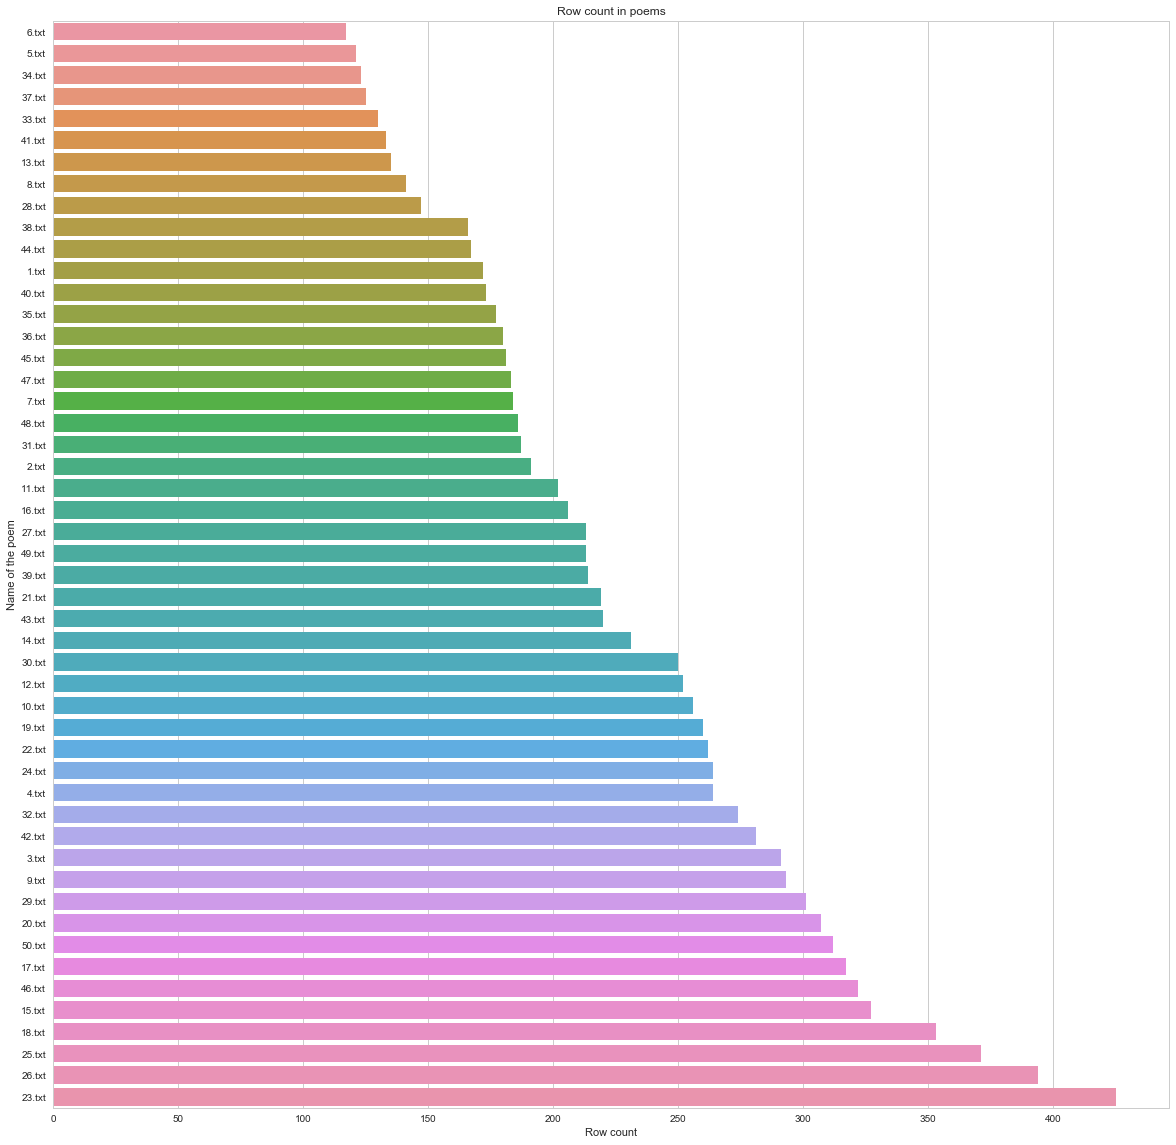

In [202]:
plt.figure(figsize=(20,20))
plotfig=sn.barplot(y='poem_name', x='row_count', data=df.sort_values(by='row_count'))
plt.xlabel('Row count')
plt.ylabel('Name of the poem')
plt.title("Row count in poems")
plt.show(plotfig)


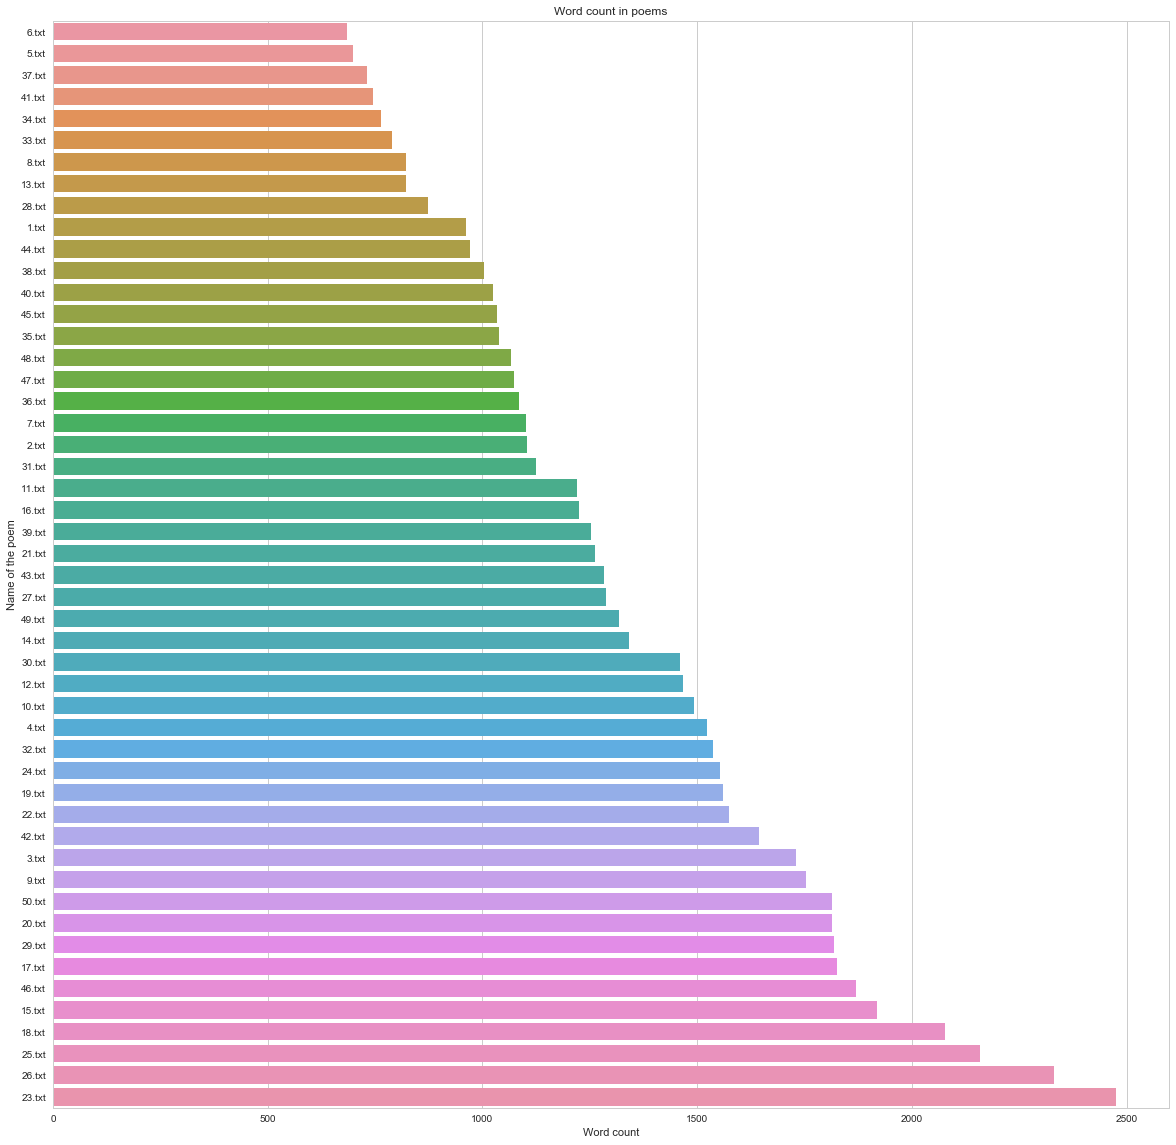

In [203]:
plt.figure(figsize=(20,20))
plotfig=sn.barplot(y='poem_name', x='word_count', data=df.sort_values(by='word_count'))
plt.xlabel('Word count')
plt.ylabel('Name of the poem')
plt.title("Word count in poems")
plt.show(plotfig)

We can see that row count and word count correlate quite well. There is also quite a difference in those statistics between poems.

Next we'll find the top 10 keywords for each poem. Let's calculate tf-idf for each poem:

In [204]:
poem_names=np.array([name for name, poem in cleaned_poems])

In [205]:
corpus=map(lambda x: ' '.join(x[1]), cleaned_poems)

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)
voc=np.array(vectorizer.get_feature_names())

dense=tfidf.todense()

And then create a function that returns n top keywords for each poem. Then we add them to DataFrame, and can query top words for each poem.

In [362]:
def top_keywords_in_poem(Xtr, words, poems, poem_name, n=10):
    #Find index of given poem
    row_id=np.where(poems==poem_name)

    # Flatten tf-idf of words for the poem
    row = np.squeeze(Xtr[row_id].A[0])
    #Find indexes of highest tf-idf
    topn_ids = np.argsort(row)[::-1][:n]
    # map top words with their corresponding tf-idf
    top_feats = [(poem_name, words[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['poem', 'word', 'tfidf']
    return df.sort_values(by='tfidf', ascending=False)

In [368]:
top_keywords=pd.DataFrame()
for name in poem_names:
    top_keywords=pd.concat([top_keywords, top_keywords_in_poem(tfidf, voc, poem_names, name, 5)])

Then we calculate pairwise cosine similarity for all poem in order to figure out how similar they are to each other.

In [381]:
dist_matrix=pairwise.pairwise_distances(tfidf, metric='cosine')

In [382]:
dist_df=pd.DataFrame(data=dist_matrix, columns=df['poem_name'].unique(), index=df['poem_name'].unique())


For visualizing the similarity of poem, we use multidimensional scaling (MDS). It aims to represent the distance in geometrical space, in this case to two-dimensional space.

In [210]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(dist_df)

In [211]:
xs, ys = pos[:, 0], pos[:, 1]

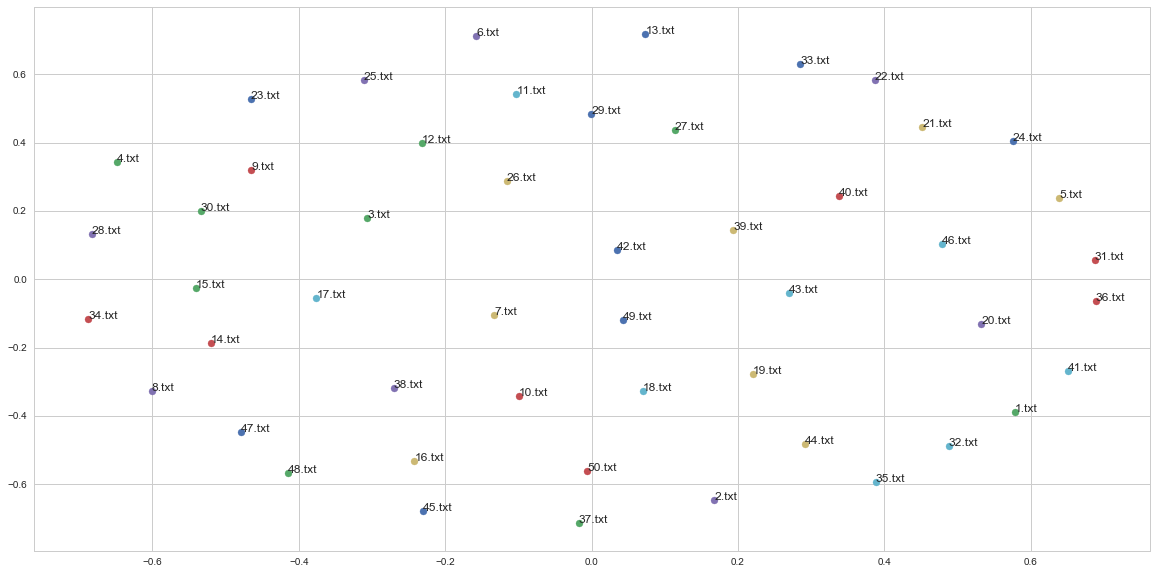

In [212]:
plt.figure(figsize=(20,10))
for x, y, name in zip(xs, ys, poem_names):
    plt.scatter(x, y)
    plt.text(x, y, name) 

For example 31.txt and 36.txt seem to be quite similar. Let's see what their top 5 keywords are.

In [385]:
top_keywords[top_keywords['poem']=='31.txt']

,poem,word,tfidf
0,31.txt,kalervon,0.301131
1,31.txt,untamo,0.283493
2,31.txt,poika,0.168738
3,31.txt,kullervo,0.140528
4,31.txt,rukihit,0.128860


In [386]:
top_keywords[top_keywords['poem']=='36.txt']

,poem,word,tfidf
0,36.txt,kullervo,0.311228
1,36.txt,kalervon,0.292921
2,36.txt,kuolleheksi,0.244447
3,36.txt,poika,0.170076
4,36.txt,kuollut,0.139911


They seem to share 3/5 top keywords, so it makes sense that they're visualized as close to each other.